In [3]:
from src.utilities import *
from src.pipeline import *


# These would be your actual system parameters
NUM_BANDS = 224

WATCH_FOLDER = 'data/'

# How often to check for new folders (in seconds).
POLL_INTERVAL_SECONDS = 10

# A file to keep track of already processed folders.
PROCESSED_LOG_FILE = 'processed_folders.log'

# --- PROCESSING PARAMETERS ---
SLIDE_STEP = 320
WINDOW_WIDTH = 2048

# Define the start and end GPS coordinates for the entire scan
# These might need to be read from a file specific to each scan in the future.
START_POINT_GPS = (50.773636, 5.154737)
END_POINT_GPS = (50.773885, 5.154849)


def process_folder(folder_path, models, images, weight_config_params, weight_images, config, oldRGBTechnique=False):
    """
    This function contains the main data processing logic for a single folder.
    """
    print(f"\n{'=' * 30}\nProcessing new folder: {os.path.basename(folder_path)}\n{'=' * 30}")
    try:
        # --- DATA LOADING ---
        data_locations = data_finder(folder_path)
        hdr = sp.envi.open(data_locations['hdr'], data_locations['img'])
        hsi_data_cube = hdr.load()
        print(f'-> HSI data cube loaded with shape: {hsi_data_cube.shape}')

        # --- PRE-PROCESSING ---
        hsi_data_cube_RGB = hsi_data_cube.transpose(1, 0, 2)[::-1]
        print('-> Data cube has been transposed for processing.')

        if config.get('dataLoader.normalize', True):
            # Assuming images['scaler_images'] is a tuple (mean, std)
            mean_scaler = images.scaler_images[0]
            std_scaler = images.scaler_images[1]
            hsi_data_cube = (hsi_data_cube_RGB - mean_scaler[np.newaxis, np.newaxis, :]) / std_scaler[
                np.newaxis, np.newaxis, :]
            print("-> Data cube has been normalized.")

        HSI_HEIGHT, HSI_WIDTH, _ = hsi_data_cube.shape
        print(f'-> Processed HSI dimensions: Height={HSI_HEIGHT}, Width={HSI_WIDTH}')

        # --- SLIDING WINDOW PROCESSING ---
        bunch_tracker = bunchTracker(match_threshold=75, slide_step=SLIDE_STEP)
        all_results = []

        processing_range = range(0, HSI_WIDTH - WINDOW_WIDTH + 1, SLIDE_STEP)
        total_steps = len(processing_range)
        print(f"-> Beginning sliding window processing across {total_steps} windows...")

        for i, start_x in enumerate(processing_range):
            end_x = start_x + WINDOW_WIDTH
            print(f"--- Processing Window {i + 1}/{total_steps}: pixels {start_x}-{end_x} ---", end='\r')

            current_window = np.array(hsi_data_cube[:, start_x:end_x, :])
            current_window_RGB = np.array(hsi_data_cube_RGB[:, start_x:end_x, :])

            current_gps = interpolate_gps(START_POINT_GPS, END_POINT_GPS, i, total_steps)

            window_results = process_single_window(
                current_window, current_window_RGB, models, bunch_tracker,
                current_gps, i, images, start_x, weight_config_params['config'],
                weight_images, rgbTechnique=oldRGBTechnique, confidence=0.4
            )

            if window_results:
                all_results.extend(window_results)

        print("\n--- Sliding window processing complete. ---")

        # --- FINAL OUTPUT AND VISUALIZATION ---
        print("\n=== FOLDER PROCESSING COMPLETE ===")
        print(f"A total of {len(all_results)} grape bunches were detected and analyzed.")
        if all_results:
            print("Final aggregated data:")
            for res in all_results[:5]:  # Print first 5 results as a sample
                print(
                    f"  - Grape ID: {res.get('bunch_id', 'N/A')}, "
                    f"Coords: ({res.get('coordinates', (0, 0))[0]:.4f}, {res.get('coordinates', (0, 0))[1]:.4f}), "
                    f"Weight: {res.get('predicted_weight_g', 0):.1f}g"
                )
            if len(all_results) > 5:
                print("  ...")

        # Create RGB visual for the entire scan
        rgb_bands = [114, 58, 20]  # Example bands for visualization
        hsi_data_cube_RGB_test = hsi_data_cube_RGB[:, :, rgb_bands]

        # Simple normalization for visualization
        if oldRGBTechnique:
            histogram, bin_edges = np.histogram(hsi_data_cube_RGB_test, bins=10)
            scale = bin_edges[-1]
            hsi_data_cube_RGB_test = hsi_data_cube_RGB_test / scale
            hsi_data_cube_RGB_test = np.clip(hsi_data_cube_RGB_test, 0, 1)
            image_RGB = np.sqrt(hsi_data_cube_RGB_test)
            image_RGB_pil = Image.fromarray((image_RGB * 255).astype(np.uint8))

        else:
            hsi_data_cube_RGB_test = np.clip(hsi_data_cube_RGB_test / np.percentile(hsi_data_cube_RGB_test, 98), 0, 1)
            image_RGB = np.sqrt(hsi_data_cube_RGB_test)
            image_RGB_pil = Image.fromarray((image_RGB * 255).astype(np.uint8))

        # Generate final map
        # TODO: This will save a file. Consider saving it into an 'output' folder
        # with a name corresponding to the input folder.
        create_final_map_png_2(image_RGB_pil, all_results, output_path=f"results/{os.path.basename(folder_path)}.png", saveFig=True, showFig=True)

        print(f"\nSuccessfully finished processing: {os.path.basename(folder_path)}")
        return True

    except Exception as e:
        print(f"\n\nERROR: An error occurred while processing {folder_path}.")
        print(f"Error details: {e}")
        import traceback
        traceback.print_exc()
        return False


def get_processed_folders():
    """Reads the log file to get a set of folders that are already processed."""
    if not os.path.exists(PROCESSED_LOG_FILE):
        return set()
    with open(PROCESSED_LOG_FILE, 'r') as f:
        return set(line.strip() for line in f)

def log_processed_folder(folder_path):
    """Appends a successfully processed folder to the log file."""
    with open(PROCESSED_LOG_FILE, 'a') as f:
        f.write(folder_path + '\n')

def main_pipeline():
    """
    Main function to run the pipeline. It watches a folder and triggers
    processing for new subfolders.
    """
    print("--- HYPERSPECTRAL PROCESSING PIPELINE ---")
    print(f"Watching folder: {WATCH_FOLDER}")
    print(f"Checking for new data every {POLL_INTERVAL_SECONDS} seconds.")
    print("Press Ctrl+C to stop the pipeline.")

    # Load machine learning models and other dependencies once at the start
    models, weight_config_params, weight_images, images, config = load_models_data()
    images.normalize = 1

    processed_folders = get_processed_folders()
    print(f"Found {len(processed_folders)} previously processed folders.")

    try:
        while True:
            # Get the list of all subdirectories in the watch folder
            try:
                current_folders = {
                    os.path.join(WATCH_FOLDER, d)
                    for d in os.listdir(WATCH_FOLDER)
                    if os.path.isdir(os.path.join(WATCH_FOLDER, d))
                }
            except FileNotFoundError:
                print(f"ERROR: Watch folder not found: {WATCH_FOLDER}. Please check the path. Retrying...")
                time.sleep(POLL_INTERVAL_SECONDS)
                continue

            # Determine which folders are new
            new_folders = sorted(list(current_folders - processed_folders))

            if new_folders:
                print(f"\nFound {len(new_folders)} new folder(s) to process.")
                for folder_path in new_folders:
                    if process_folder(folder_path, models, images, weight_config_params, weight_images, config, False):
                        # If processing was successful, log it
                        log_processed_folder(folder_path)
                        processed_folders.add(folder_path)
            else:
                print(f"No new folders found. Sleeping for {POLL_INTERVAL_SECONDS} seconds...", end='\r')

            time.sleep(POLL_INTERVAL_SECONDS)

    except KeyboardInterrupt:
        print("\n\nPipeline stopped by user. Exiting.")

--- HYPERSPECTRAL PROCESSING PIPELINE ---
Watching folder: data/
Checking for new data every 10 seconds.
Press Ctrl+C to stop the pipeline.
Loading pre-processed data objects...
'weight_images' loaded.
'images' loaded.
Found 0 previously processed folders.

Found 1 new folder(s) to process.

Processing new folder: 20250926_FX10_sweep_voorkant_2025-09-26_13-32-49
-> HSI data cube loaded with shape: (5423, 1024, 224)
-> Data cube has been transposed for processing.
-> Data cube has been normalized.
-> Processed HSI dimensions: Height=1024, Width=5423
-> Beginning sliding window processing across 11 windows...
image is created and processed for saving ---

0: 320x640 1 grapeBunch, 518.6ms
Speed: 5.7ms preprocess, 518.6ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)
Detected 1 raw bunches, 1 are fully in frame.
--- Processing NEW centered Bunch ID: 0 ---
SavGol GPU filter initialized on device: cpu
Found 6624 patches, randomly sampling down to 50.
Extracted 50 patches f

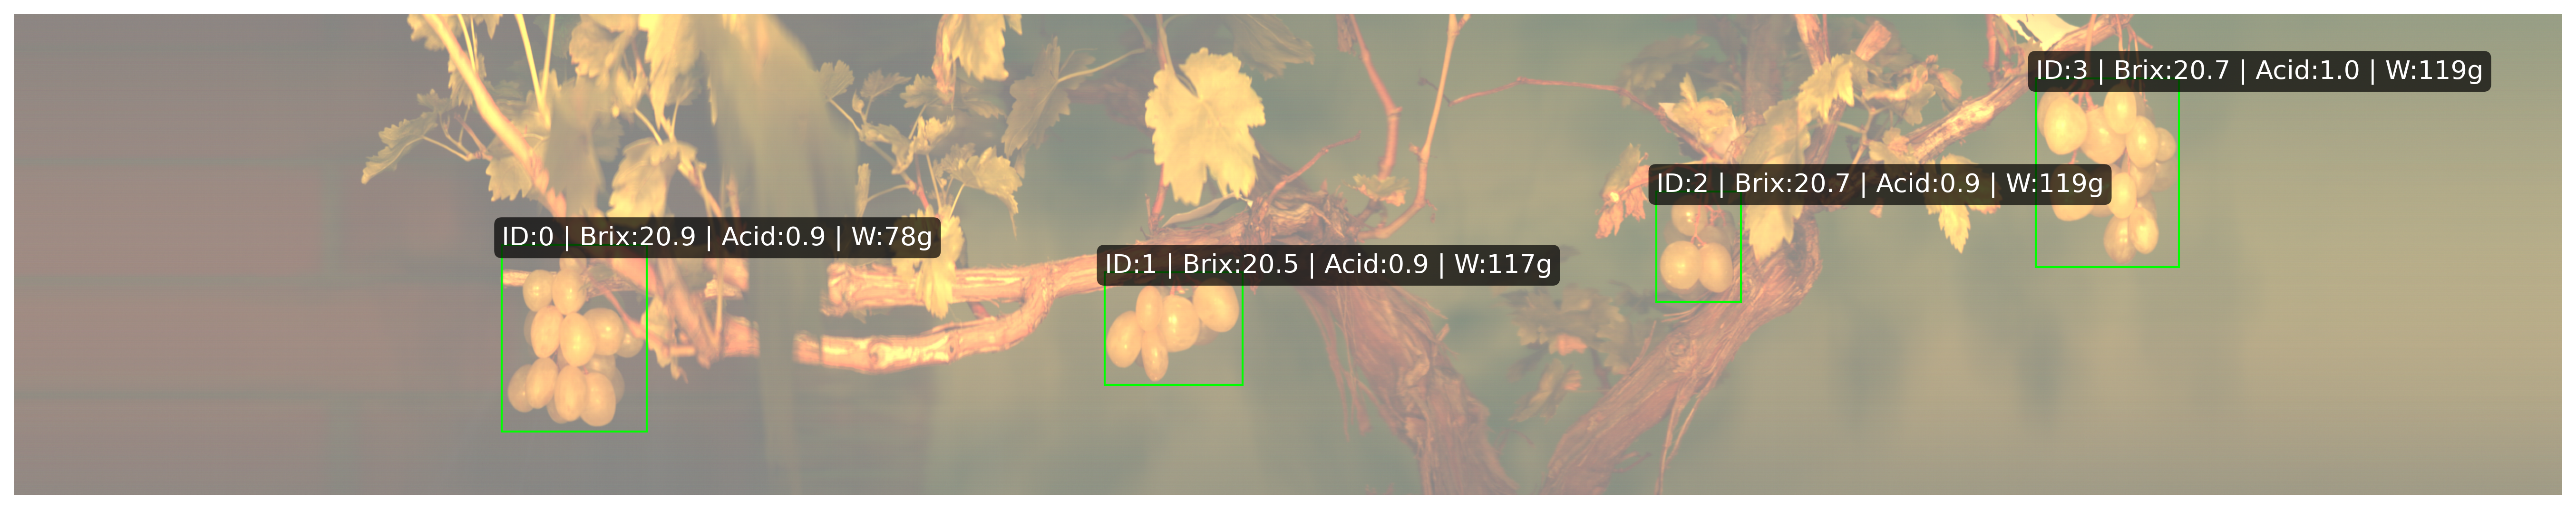


Successfully finished processing: 20250926_FX10_sweep_voorkant_2025-09-26_13-32-49


In [ ]:
main_pipeline()